# Example for the `Speech-To-Text (STT)` API

This notebook illustrates how to build a pretrained `Whisper` model, and use it to transcribe an audio file !

Models are converted, from either the official `openai` checkpoints, either from the `transformers` models checkpoints, from `pytorch` to a `keras` instance. For this purpose, both your keras backend, and `torch` have to be installed. Once the model has been converted, `torch` is not required anymore ;) 

Currently, only `tensorflow` backend has been tested, and the `logit filtering` strategy used in the original implemenetation is not properly working. However, this does not really affect the overall prediction quality ;) (it will be solved in the next update)

The `tts` method works on both audios and videos !

## Build whisper

[Whisper](https://github.com/openai/whisper) is a multilingual `Speech-to-Text` model trained by `OpenAI`.

**WARNING** : `pytorch` is required to convert the official `pytorch` checkpoint to a `keras` checkpoint ;)

**Important Note** : the tokenizer is now copied from the `transformers` library, as the new official `openai`'s code is using their custom `tiktoken` tokenizer. This means that the 2 tokenizers are not *exactly* identical, but are compatible as the differences do not have any impact on the model.

In [5]:
from models.stt import Whisper

model = Whisper(pretrained = 'base', lang = 'multi', nom = 'whisper-base')
print(model)


========== whisper-base ==========
Model instance `stt_model`
- Inputs 	: unknown
- Outputs 	: unknown
- Number of layers 	: 2
- Number of parameters 	: 71.826 Millions
- Model not compiled yet

Transfer-learning from : base
Already trained on 0 epochs (0 steps)

- Language : multi
- Vocabulary (size = 50364) : ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ...]
- Audio rate : 16000
- # mel channels : 80
- Use CTC decoder : False



## Prediction API

The prediction API is very simple to use : pass the audio filename(s), and the model you want (or the audio language) and that's it !

The prediction splits the audio into *chunks* of a given amount of time (default to 30sec), and predicts the text for each chunk. Then it concatenates all the texts to build the complete transcription of the audio file ! Note that `Whisper` also splits each chunk into frames corresponding to the timestamps of the transcription (these are provided in the output). This may be useful to search a span of text, or even complete / correct the transcription ! 

This demonstration is performed on a short and clean audio. Nevertheless, `Whisper` has been trained on large scale datasets, and is able to transcribe audios in many languages, even in noisy or low quality audios !

`Whisper` is a multilingual model, meaning that it can transcribe audios from a large variety of languages. However, it has to know which language it should use. To this end, the 1st prediction step is to detect the language from the audio. To skip this part, and thus speed up the prediction time, you can provide the `lang` argument ;)

The inference method of `Whisper` is now compatible with the [XLA](https://www.tensorflow.org/xla) optimization ! This makes the model much faster than in eager (sequential) mode, at the cost of a much slower 1st call, as it needs to compute the execution graph. The inference can be executed in 3 different modes : 
- Eager (sequential) (`run_eagerly = True`) : slowest mode, but do not have any compilation time
- Graph mode (`use_xla = False`) (only available for `tensorflow` backend) : compiles the function with `tf.function(jit_compile = False)`, which is a good trade-off between speed and compilation time
- XLA (`use_xla = True`) : fastest mode, at the cost of a much slower 1st call

Here is a short benchmark on my `RTX 3090` on the given audio with `num_sentences = 5, num_beams = 10` :
- Eager : 877 ms - 889 ms
- Graph : 1.918 sec - 151 ms
- XLA : 5.067 sec - 42 ms

**Known issue** : the `end` currently does not properly care about the padding expected by Whisper. This is the reason why the "end" timestamp is 30, while the audio is only 5sec long. This is also an issue for the `search` method shown below. This will be solved in the next update ;)

In [2]:
from loggers import set_level
from models.stt import transcribe
from utils.audio import display_audio

set_level('time')

filename = 'audio_en.wav'
pred = transcribe(filename, model = 'whisper-base', save = False, lang = 'en', use_xla = True, verbose = False)

#display_audio(filename)
pred

Timers :
- predict : 49 ms
  - initialization : 165 μs
    - _add_data : 71 μs
  - loading audio : 26 ms
    - read_audio : 23 ms
      - read file : 23 ms
      - normalize_audio : 491 μs
    - mel_spectrogram : 1.160 ms
    - trim_silence : 907 μs
  - segment processing : 491 μs
  - inference : 20 ms
  - post_processing : 135 μs


[({},
  {'text': 'The streets were narrow and unpaid but very fairly clean.',
   'alignment': [{'id': -1,
     'start': 0.0,
     'end': 4.04,
     'num': 0,
     'time': 4.04,
     'text': 'The streets were narrow and unpaid but very fairly clean.',
     'tokens': array([  440,  8481,   645,  9432,   293,   517, 35035,   457,   588,
             6457,  2541,    13], dtype=int32),
     'score': 0,
     'lang': 'en'}],
   'filename': 'audio_en.wav',
   'audio': 'audio_en.wav'})]

## Search keyword in audio

The `search` function allows to search a keyword in an audio / video, and get all timestamps where this keyword has been found (with a given probability threshold). Even though the model is quite accurate, it can make some spelling mistakes, like in the given audio (i.e., the *unpaid* should be *unpaved*). To mitigate this in the matching function, the `Edit` distance (aka `Levenshtein distance`) is used with a *partial* alignment to find all occurences with a given tolerance. 

Once the positions of the candidates have been found, its approximate timestamp is provided based on its relative position, and the time information of the segments. 

In [3]:
import os

from utils import load_json
from models import get_model_dir
from models.stt import search, get_model_name

model_name = 'whisper-base'
filename = 'audio_en.wav'

print("Model name : {}".format(model_name))
r = search('clean', filename, model = model_name)
print(r)
print(get_model_dir(model_name, 'search', 'map.json'))
print("Filename is in processed file : {}".format(filename in load_json(get_model_dir(model_name, 'outputs', 'map.json'))))

Model name : whisper-base
Result for searching keyword 'clean' :
Number of files : 1 / 1
Total number of occurences : 1
Files : Annotation of file audio_en.wav :
- Total annotation time : 30.000 sec
- Number of alignments : 1 (1 sub-parts)
- Speakers (n = 1) : [-1]

Occurences of 'clean' (1, threshold = 80.00%) :
- Timestamp 26.316 sec (p = 100.00 %) : [...]  clean. [...]

pretrained_models/whisper-base/search/map.json
Filename is in processed file : False


In [ ]:
r.display(before = 0.5)

## Edit distance demonstration

This example illustrates with longer example the **edit distance** with partial alignment for searching keyword in bad-spelled text (as described in the README file). 

The objective is to find *cat* in the text *the ct is here*

In [3]:
import numpy as np

from loggers import set_level
from utils import plot, set_display_options
from utils.distance import edit_distance

set_level('info')
set_display_options()

truth = 'the ct is here'
hypothesis = 'cat'

print("Edit distance without partial alignment :")
dist, matrix = edit_distance(hypothesis, truth, partial = False, return_matrix = True, normalize = False, verbose = True)

print("Edit distance with partial alignment :")
partial_dist, partial_matrix = edit_distance(hypothesis, truth, partial = True, return_matrix = True, normalize = False, verbose = True)

start_idx = np.argmin(partial_matrix[-1, 1:]) + 1 - len(hypothesis)
print("Best alignment : {}".format(truth[start_idx : start_idx + len(hypothesis)]))

Edit distance without partial alignment :
          t    h    e         c    t         i    s           h     e     r     e
   0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  12.0  13.0  14.0
c  1.0  1.0  2.0  3.0  4.0  4.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
a  2.0  2.0  2.0  3.0  4.0  5.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
t  3.0  2.0  3.0  3.0  4.0  5.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
Edit distance with partial alignment :
          t    h    e         c    t         i    s         h    e    r    e
   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
c  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
a  2.0  2.0  2.0  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
t  3.0  2.0  3.0  3.0  3.0  2.0  1.0  2.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
Best alignment :  ct


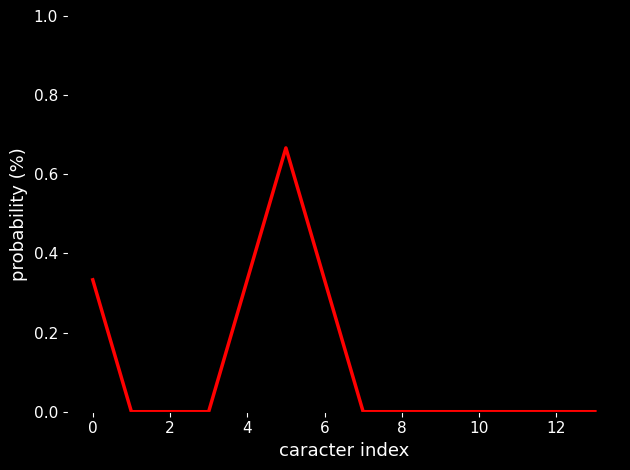

In [6]:
probability = 1. - partial_matrix[-1, 1:] / len(hypothesis)
plot(probability, ylim = (0, 1), xlabel = "caracter index", ylabel = "probability (%)")